In [21]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [22]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import re

In [23]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [24]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    # Creating a new variable data_line_vals equal to the data_line
    data_line_vals = data_line
    # Label takes the 2nd column of data_line_vals which is being passed throught the convert_label function
    label = convert_label(data_line_vals[1])
    # Statement takes the 3rd column of the data_line_vals
    statement = data_line_vals[2]
    # Returns a tuple of the label as just FAKE or REAL with the statement
    return (label, statement)

In [25]:
def pre_process(text):
    # This removes non-alphanumeric characters from the text e.g. all punctuation and special characters.
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Now we can split the text on the white-space
    tokens = re.split(r"\s+",text)
    # normalisation all the tokens to lowercase
    tokens = [t.lower() for t in tokens]
    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [26]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    # Should return a dictionary containing features as keys, and weights as values
    # Creating the local dictionary
    feature_dict = {}
    # Using a for loop to assign equal weights to each token
    for token in tokens:
        if token not in feature_dict.keys():
            feature_dict[token] = 1
        else:
            feature_dict[token] = 1
    # Creating Vocab variable to then help me update global dictionary
    vocab = feature_dict
    global_feature_dict.update(vocab)
    return feature_dict

In [27]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [28]:
#solution
from sklearn.metrics import classification_report


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1 #length of dataset/10 + 1 to split the data evenly. so 10 + 1. We add one to allow us to have 10 folds, as python starts at 0.
    
    for i in range(0,len(dataset),int(fold_size)): # range(start at 0, stop at the end of the dataset, for each fold)
        # Trains and tests on the 10 folds of data in the dataset
        train_sample = dataset[:i] + dataset[i+fold_size:]
        test_sample = dataset[i:i+fold_size]
        # Creating the variable cv for the classifier 
        cv = train_classifier(train_sample)
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # Separting the statements and labels in order to pass the statements through the predict labels function
        test_sample_x = [i[0] for i in test_sample]
        test_sample_y = [i[1] for i in test_sample]
        predicted_labels = predict_labels(test_sample_x,cv)
        # Using output_dict=True to access the scores from each fold
        report = classification_report(test_sample_y,predicted_labels,output_dict=True)
        print(report)
        # Defining precision to compute average
        precision = report['REAL']['precision']
        precision_list = []
        precision_list.append(precision)
        #results.append(cv_results)
        avg_precision = np.mean(precision_list)
        # Defining recall to compute average
        recall = report['REAL']['recall']
        recall_list = []
        recall_list.append(recall)
        avg_recall = np.mean(recall_list)
        # Defining f1 score to compute average
        f1_score = report['REAL']['f1-score']
        f1_score_list = []
        f1_score_list.append(f1_score)
        avg_f1_score = np.mean(f1_score_list)
        # Defining accuracy to compute average
        acc = report['accuracy']
        acc_list = []
        acc_list.append(acc)
        avg_acc = np.mean(acc_list)
        # cv_results will now store averages across all folds
        cv_results = [avg_precision,avg_recall,avg_f1_score,avg_acc]
    print(f"The results for my classifier are:\n{cv_results}")
    

In [29]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [39]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'data/fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
12229


In [31]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Training Classifier...
Fold start on items 0 - 820
{'FAKE': {'precision': 0.46938775510204084, 'recall': 0.4749262536873156, 'f1-score': 0.47214076246334313, 'support': 339.0}, 'REAL': {'precision': 0.6268343815513627, 'recall': 0.6216216216216216, 'f1-score': 0.6242171189979123, 'support': 481.0}, 'accuracy': 0.5609756097560976, 'macro avg': {'precision': 0.5481110683267018, 'recall': 0.5482739376544686, 'f1-score': 0.5481789407306277, 'support': 820.0}, 'weighted avg': {'precision': 0.5617436420802405, 'recall': 0.5609756097560976, 'f1-score': 0.5613465276988648, 'support': 820.0}}
Training Classifier...


/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 820 - 1640
{'FAKE': {'precision': 0.49731182795698925, 'recall': 0.49333333333333335, 'f1-score': 0.4953145917001338, 'support': 375.0}, 'REAL': {'precision': 0.5758928571428571, 'recall': 0.5797752808988764, 'f1-score': 0.5778275475923852, 'support': 445.0}, 'accuracy': 0.5402439024390244, 'macro avg': {'precision': 0.5366023425499231, 'recall': 0.5365543071161049, 'f1-score': 0.5365710696462596, 'support': 820.0}, 'weighted avg': {'precision': 0.5399564108688322, 'recall': 0.5402439024390244, 'f1-score': 0.540092964105075, 'support': 820.0}}
Training Classifier...
Fold start on items 1640 - 2460


/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


{'FAKE': {'precision': 0.527536231884058, 'recall': 0.4642857142857143, 'f1-score': 0.4938941655359566, 'support': 392.0}, 'REAL': {'precision': 0.5578947368421052, 'recall': 0.6191588785046729, 'f1-score': 0.5869324473975637, 'support': 428.0}, 'accuracy': 0.5451219512195122, 'macro avg': {'precision': 0.5427154843630816, 'recall': 0.5417222963951935, 'f1-score': 0.5404133064667601, 'support': 820.0}, 'weighted avg': {'precision': 0.5433818905694777, 'recall': 0.5451219512195122, 'f1-score': 0.5424556102149417, 'support': 820.0}}
Training Classifier...
Fold start on items 2460 - 3280
{'FAKE': {'precision': 0.5165745856353591, 'recall': 0.5238095238095238, 'f1-score': 0.5201668984700973, 'support': 357.0}, 'REAL': {'precision': 0.62882096069869, 'recall': 0.6220302375809935, 'f1-score': 0.6254071661237784, 'support': 463.0}, 'accuracy': 0.5792682926829268, 'macro avg': {'precision': 0.5726977731670245, 'recall': 0.5729198806952587, 'f1-score': 0.572787032296938, 'support': 820.0}, 'wei

/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 3280 - 4100
{'FAKE': {'precision': 0.49271137026239065, 'recall': 0.48563218390804597, 'f1-score': 0.4891461649782923, 'support': 348.0}, 'REAL': {'precision': 0.6247379454926625, 'recall': 0.6313559322033898, 'f1-score': 0.6280295047418336, 'support': 472.0}, 'accuracy': 0.5695121951219512, 'macro avg': {'precision': 0.5587246578775266, 'recall': 0.5584940580557178, 'f1-score': 0.5585878348600629, 'support': 820.0}, 'weighted avg': {'precision': 0.5687071550290838, 'recall': 0.5695121951219512, 'f1-score': 0.569088770305599, 'support': 820.0}}
Training Classifier...
Fold start on items 4100 - 4920
{'FAKE': {'precision': 0.4730878186968839, 'recall': 0.4785100286532951, 'f1-score': 0.47578347578347585, 'support': 349.0}, 'REAL': {'precision': 0.6102783725910065, 'recall': 0.6050955414012739, 'f1-score': 0.6076759061833689, 'support': 471.0}, 'accuracy': 0.551219512195122, 'macro avg': {'precision': 0.5416830956439451, 'recall': 0.5418027850272845, 'f1-score': 0.5417

/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5740 - 6560
{'FAKE': {'precision': 0.49157303370786515, 'recall': 0.49019607843137253, 'f1-score': 0.4908835904628331, 'support': 357.0}, 'REAL': {'precision': 0.6077586206896551, 'recall': 0.6090712742980562, 'f1-score': 0.6084142394822007, 'support': 463.0}, 'accuracy': 0.5573170731707318, 'macro avg': {'precision': 0.5496658271987601, 'recall': 0.5496336763647144, 'f1-score': 0.5496489149725169, 'support': 820.0}, 'weighted avg': {'precision': 0.55717538343051, 'recall': 0.5573170731707318, 'f1-score': 0.5572454081408419, 'support': 820.0}}
Training Classifier...
Fold start on items 6560 - 7380
{'FAKE': {'precision': 0.48578811369509045, 'recall': 0.5179063360881543, 'f1-score': 0.5013333333333333, 'support': 363.0}, 'REAL': {'precision': 0.5958429561200924, 'recall': 0.5645514223194749, 'f1-score': 0.5797752808988764, 'support': 457.0}, 'accuracy': 0.5439024390243903, 'macro avg': {'precision': 0.5408155349075914, 'recall': 0.5412288792038146, 'f1-score': 0.5405

/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 7380 - 8200
{'FAKE': {'precision': 0.5111731843575419, 'recall': 0.5495495495495496, 'f1-score': 0.5296671490593343, 'support': 333.0}, 'REAL': {'precision': 0.6696035242290749, 'recall': 0.6346555323590815, 'f1-score': 0.6516613076098606, 'support': 479.0}, 'accuracy': 0.5997536945812808, 'macro avg': {'precision': 0.5903883542933084, 'recall': 0.5921025409543155, 'f1-score': 0.5906642283345975, 'support': 812.0}, 'weighted avg': {'precision': 0.6046314759812663, 'recall': 0.5997536945812808, 'f1-score': 0.6016316834752236, 'support': 812.0}}
The results for my classifier are:
[0.6696035242290749, 0.6346555323590815, 0.6516613076098606, 0.5997536945812808]


# 4. Error Analysis (10 marks)

In [40]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_true=y_test, y_pred=preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.savefig('results/Confusion Matrix Original', dpi=300)
    plt.show() # ta-da!
    plt.show()

In [33]:
# Our classfier
cv = train_classifier(train_data)
# Repeat the process in cross validate but now for the test data
test_x = [i[0] for i in test_data]
test_y = [i[1] for i in test_data]
pred = predict_labels(test_x,cv)
cv_results = classification_report(test_y,pred)

print(cv_results)

Training Classifier...
              precision    recall  f1-score   support

        FAKE       0.50      0.50      0.50       926
        REAL       0.59      0.60      0.59      1123

    accuracy                           0.55      2049
   macro avg       0.55      0.55      0.55      2049
weighted avg       0.55      0.55      0.55      2049



/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


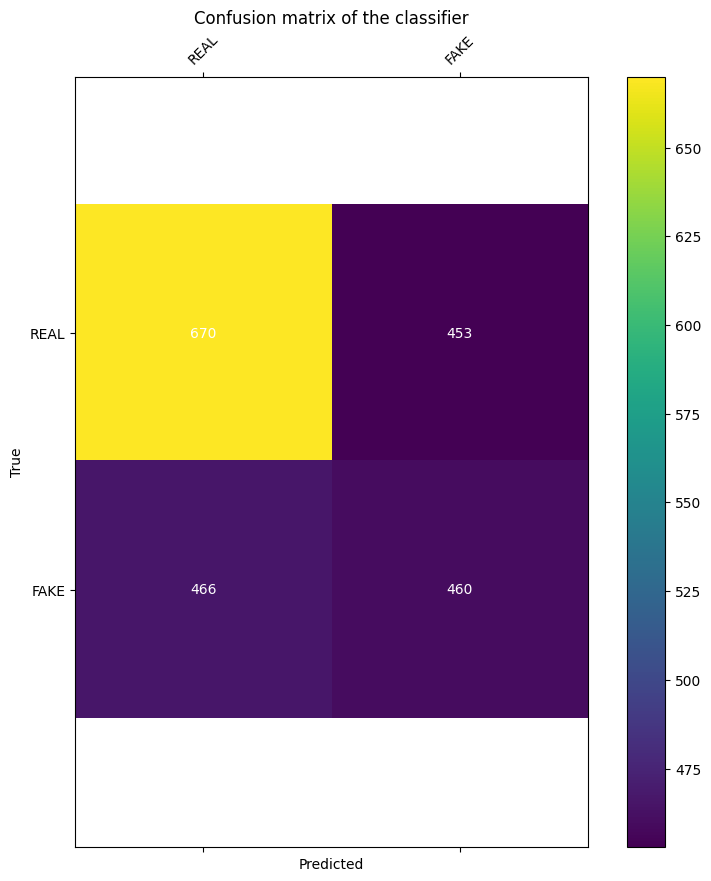

In [41]:
confusion_matrix_heatmap(test_y, pred, labels=['REAL','FAKE'])

In [35]:
# Looking at the 1st fold.
fold_size = int((len(test_data)/10)+1)
# Accessing the 1st fold
test_sample = test_data[0:0+fold_size]
# The statement from the test sample
err_test_x = [i[0] for i in test_sample]
# The label from the test sample
err_test_y = [i[1] for i in test_sample]
err_pred = predict_labels(err_test_x,cv)

In [42]:
for i in range(len(err_pred)):
    # If the predicted label is Real
    if pred[i] == 'REAL':
        if err_test_y[i] == 'FAKE': # and the real label is Fake
            with open('results/FP.txt', 'a') as f:
                print('\nfalse positive => predicted: REAL => ground truth: FAKE\n' ,err_test_x[i], file=f)
    # Else meaing that the predicted label is Fake            
    else:
        if err_test_y[i] == 'REAL': # and the real label is Real
            with open('results/FN.txt', 'a') as f:
                print('\nfalse negative => predicted: FAKE => ground truth: REAL\n',err_test_x[i], file=f)

In [37]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'the': 1, 'bush': 1, 'tax': 1, 'cuts': 1, 'helped': 1, 'to': 1, 'create': 1, 'a': 1, 'substantial': 1, 'part': 1, 'of': 1, 'deficit': 1, '': 1}, 'REAL')
Training Classifier...
Done training!
Precision: 0.550943
Recall: 0.551489
F Score:0.551194


/Users/samson/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
